In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial', size=20)

In [2]:
# output_file = rf"./data/20251209_chi_0p37_time_domain_absorbers_L_9_Lateral_x_3.h5" #input beam 2.5a 
output_file = rf"./data/20251216_chi_0p37_time_domain_absorbers_L_9_Lateral_x_3.h5" #input beam 4.0a

data = (read_hdf5_as_dict(output_file))["simulation_data"]
samples = (read_hdf5_as_dict(output_file))["samples"]

In [3]:
import scipy.integrate
def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_2/integral_1

def calculate_sigma(intensity_array, x1):
    x1 = np.asarray(x1)
    values = intensity_array

    # Reshape x1 to broadcast over columns (axis=1)
    x1 = x1[:, np.newaxis]  

    norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
    mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
    mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
    sigma = np.sqrt(mean_sq - mean**2)
    return sigma

def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

import pandas as pd
def moving_average_pd(x, w=3):
    return pd.Series(x).rolling(window=w, center=True, min_periods=1).mean().to_numpy()

In [4]:
flux_data = [np.array([data["0.37"][nu][str(sample)]["flux"] for sample in samples]) for nu in data["0.37"].keys()]
flux_data_ref = [np.array([data["Reference"][nu][str(sample)]["flux"] for sample in [0.0]]) for nu in data["Reference"].keys()]
intensity_data = [np.array([data["0.37"][nu][str(sample)]["intensity"] for sample in samples]) for nu in data["0.37"].keys()]

C:\Users\HernandF\AppData\Local\Temp\ipykernel_58448\3726314508.py:61: RuntimeWarning: invalid value encountered in divide
  intensity_normalized = intensity_values/max_values_time_step
C:\Users\HernandF\AppData\Local\Temp\ipykernel_58448\859791219.py:17: RuntimeWarning: invalid value encountered in divide
  mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_58448\859791219.py:18: RuntimeWarning: invalid value encountered in divide
  mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
c:\Users\HernandF\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\HernandF\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


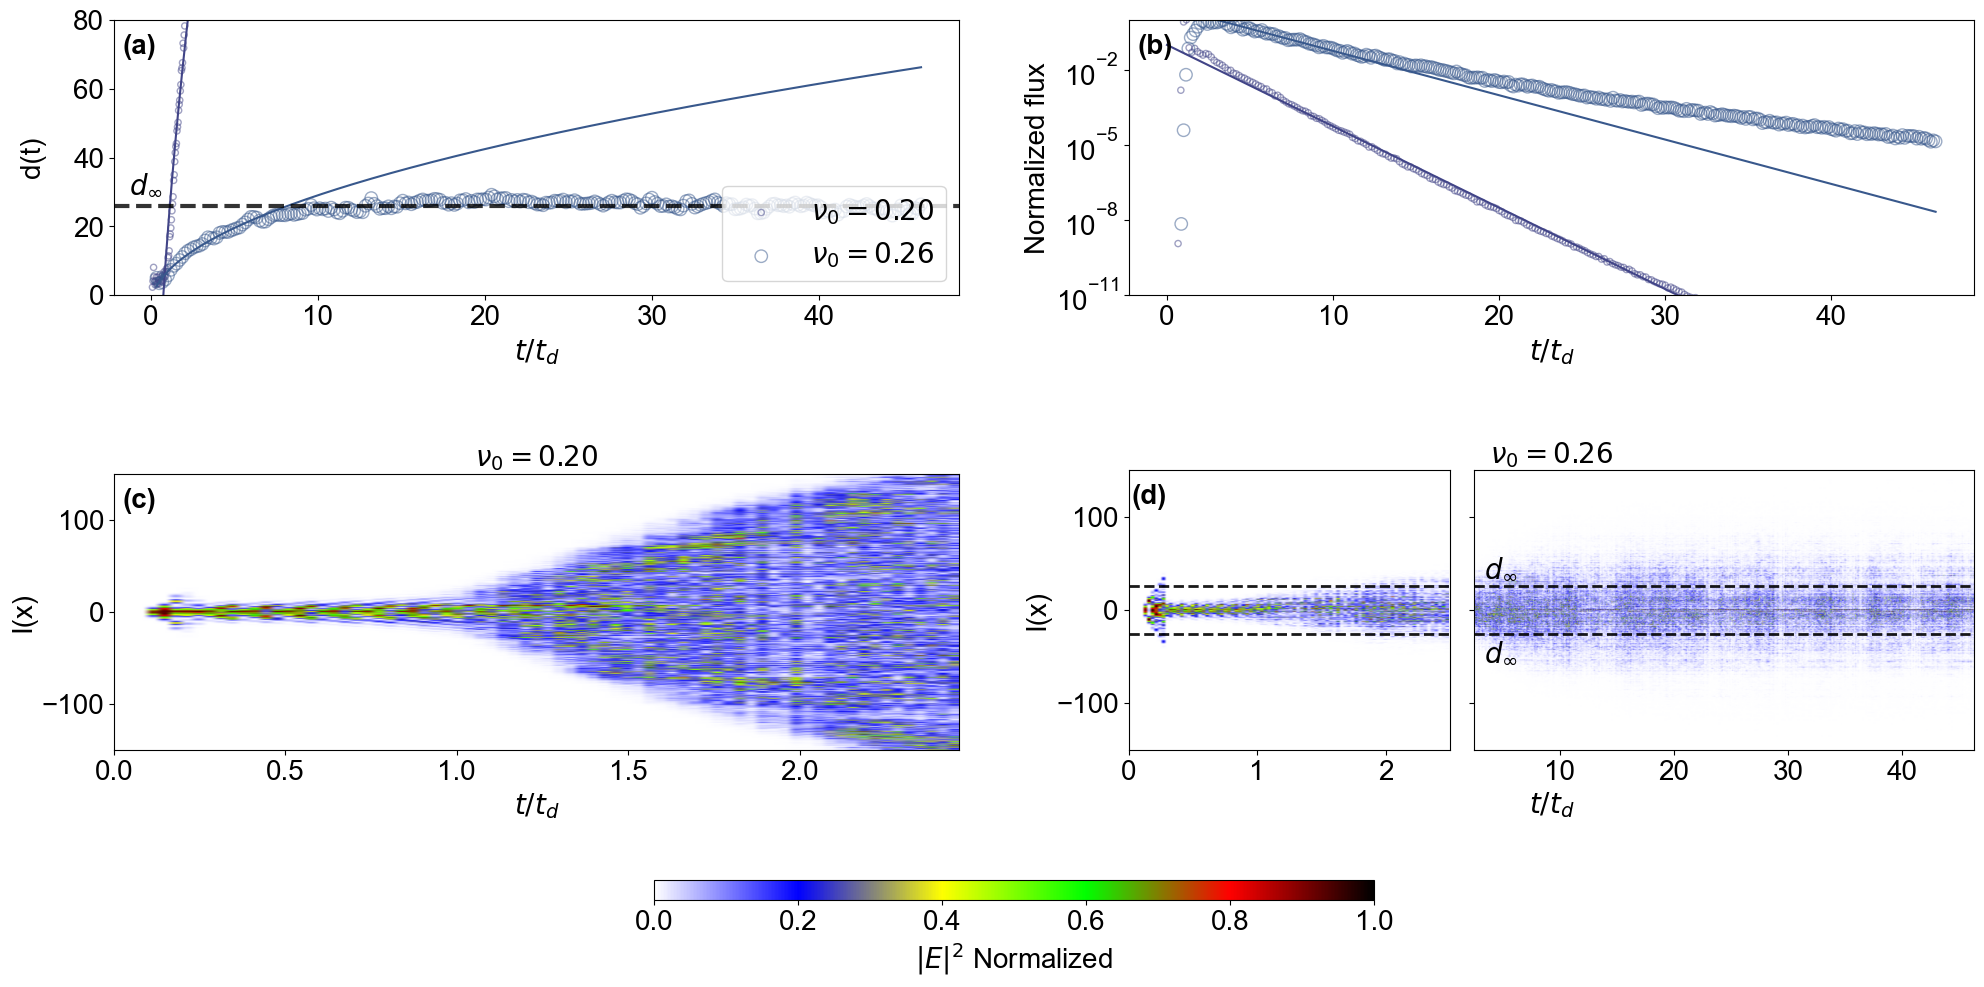

In [33]:
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
# Create a custom colormap
colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

 # create a degrading set of colors (bright -> pale)
n_lines = 4
cmap_2= plt.cm.viridis
colors_lines = cmap_2(np.linspace(0.2,0.41, n_lines))


fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(24,10))
flatten_ax = ax.flatten()
normalization_time=[]
for i, nu in enumerate(data["0.37"].keys()):
    flux = np.mean(flux_data[i],axis=0)
    time_flux = data["0.37"][nu]["0.0"]["time_flux"]
    ###Reference
    time_ref = data["Reference"][nu]["0.0"]["time_flux"]
    index_max_flux_ref =np.argmax(np.mean(flux_data_ref[i],axis=0))
    normalization_time.append(time_ref[index_max_flux_ref])
    ##############
    

    time_flux_normalized = (time_flux/normalization_time[i])
    time_intensity = (data["0.37"][nu]["0.0"]["time_intensity"]/normalization_time[i])



    ####time masks########
    if i ==0:
        mask_time_intensity = (time_intensity>=0) & (time_intensity<=2.5)
    else:
        mask_time_intensity = (time_intensity>=0) 

    time_intensity = time_intensity[mask_time_intensity]
    ######################


    x_values = data["0.37"][nu]["x"]
    y_values = data["0.37"][nu]["y"]

    
    index_exit = np.argmin(np.abs(y_values - 4.5))  # Assuming you want the exit at y=4.5a

    intensity_average = np.mean(intensity_data[i],axis=(0))
    intensity_values = np.copy((intensity_average[:,index_exit,:].squeeze()))
    # intensity_values[intensity_values/np.max(intensity_values)<=1e-12]=0


    max_values_time_step = (np.max(intensity_values,axis=0))
    intensity_normalized = intensity_values/max_values_time_step
    intensity_normalized[np.isnan(intensity_normalized)] = 0
    spreading = calculate_sigma(intensity_normalized,x1=x_values-np.min(x_values))
    ############Plot intensity images##########
    t_split = 2.5  # time to split the axis
    ax_panel = flatten_ax[i+2]
    if i ==0:
         # Panels (c) and (d) normal full-image

        im = ax_panel.imshow(intensity_normalized[:,mask_time_intensity],vmin = 0, vmax = 1, 
                     extent =[np.min(time_intensity),np.max(time_intensity),np.min(x_values),np.max(x_values)], 
                         origin ='lower', cmap=cmap,aspect='auto')
        ax_panel.set_ylim(-150,150)
    else: 
         # Panels (e) and (f): create two sub-axes to simulate a broken x-axis
        push_down = -0.04 # adjust this value to move panels more/less
        pos = ax_panel.get_position()
        # remove the original axis and create two new ones in its place
        ax_panel.set_visible(False)
        left_ax = fig.add_axes([pos.x0, pos.y0 - push_down, pos.width*0.38, 
                                pos.height-0.07])
        right_ax = fig.add_axes([pos.x0 + pos.width*0.38 + 0.01, pos.y0 - push_down, pos.width*0.62 - 0.01,
                                pos.height-0.07],
                        sharey=left_ax)
        # match font sizes to the other panels
        left_ax.tick_params(which='major', labelsize=20)
        right_ax.tick_params(which='major', labelsize=20)
        left_ax.title.set_fontsize(20)
        right_ax.title.set_fontsize(20)
        # masks for left (ballistic) and right (late times)
        full_mask = mask_time_intensity
        all_times = (data["0.37"][nu]["0.0"]["time_intensity"]/normalization_time[i])[full_mask]
        left_mask = all_times <= t_split
        right_mask = all_times > t_split

        # left image (ballistic)
        if np.any(left_mask):
            im_left = left_ax.imshow(intensity_normalized[:,full_mask][:,left_mask], vmin=0, vmax=1,
                        extent=[np.min(all_times[left_mask]), np.max(all_times[left_mask]), np.min(x_values), np.max(x_values)],
                        origin='lower', cmap=cmap, aspect='auto')
        else:
            im_left = None

        # right image (late times)
        if np.any(right_mask):
            im_right = right_ax.imshow(intensity_normalized[:,full_mask][:,right_mask], vmin=0, vmax=1,
                        extent=[np.min(all_times[right_mask]), np.max(all_times[right_mask]), np.min(x_values), np.max(x_values)],
                        origin='lower', cmap=cmap, aspect='auto')
        else:
            im_right = None

        # remove overlapping y tick labels on right axis
        plt.setp(right_ax.get_yticklabels(), visible=False)
        left_ax.set_xlim(np.min(all_times), t_split)
        right_ax.set_xlim(t_split + 1e-6, np.max(all_times))


        im = im_right if im_right is not None else im_left
        # assign panel axes for setting labels/titles below
        ax_panel = left_ax  # use left for labels; right is sharey
        subplot_label = rf"({chr(99 + i)})"  # chr(65) = 'A', chr(66) = 'B', etc.
        ax_panel.text(0.01, 0.95, subplot_label, transform=ax_panel.transAxes,fontsize=20, fontweight='bold', va='top', ha='left')

        left_ax.set_ylabel("I(x)", fontsize=20)
        # left_ax.set_title(rf"$\nu_0  = {float(nu):.2f}$", fontsize=20)
        title_str = rf"$\nu_0  = {float(nu):.2f}$"
        title_x = pos.x0 + pos.width/2
        title_y = pos.y0 + pos.height-0.03   # slight offset above axes
        fig.text(title_x, title_y, title_str, ha='center', va='bottom', fontsize=20)
        fig.text(title_x, pos.y0, r'$t/t_d$', ha='center', va='top', fontsize=20)

        
        ##############


    
######Plot spreading and flux#########    
    marker_style = 'o'

    if i==1:
        marker_kwargs = dict(marker=marker_style, facecolors='none', edgecolors=colors_lines[i],alpha=0.5)  # open circle
        # increase symbol size for localized data
        base_size = 40
        s = int(base_size * 2)  # increase by factor 2
        win = 3
        out_indices=6

    else:
        # closed (filled) marker for non-localized
        marker_kwargs = dict(marker=marker_style, facecolors='none', edgecolors=colors_lines[i],alpha=0.5)  # open circle
        s = 20  # default smaller size
        win=1
        out_indices=1


  # bin / smooth points (use window 5 or fallback to 3)
    t_smooth = moving_average(time_intensity[::out_indices], w=win)
    spread_smooth = moving_average((spreading[mask_time_intensity])[::out_indices], w=win)
    spread_smooth_nan_mask = ~np.isnan(spread_smooth)
    t_smooth = t_smooth[spread_smooth_nan_mask]
    spread_smooth = spread_smooth[spread_smooth_nan_mask]
    # Fit a sqrt(t) model: f(t) = A * sqrt(t) + B
    def sqrt_model(t, A, B):
        return A * np.sqrt(np.clip(t, 0, None)) + B
    try:
        popt, pcov = curve_fit(sqrt_model, t_smooth[(t_smooth>0.55) & (t_smooth<7)], spread_smooth[(t_smooth>0.55) & (t_smooth<7)], p0=[1.0, 0.0])
        t_fit = np.linspace(np.min(t_smooth), np.max(t_smooth), 200)
        fit_curve = sqrt_model(t_fit, *popt)
        # plot fit using the same color as the markers
        flatten_ax[0].plot(t_fit, fit_curve, color=colors_lines[i], linewidth=1.5)
       
    except Exception as e:
        print("fit failed for nu", nu, e)
    flatten_ax[0].scatter(t_smooth, spread_smooth, label=rf"$\nu_0={float(nu):.2f}$", s=s, **marker_kwargs)
    if spread_smooth.size > 0 and not np.all(np.isnan(spread_smooth)):
        max_spread = np.mean(spread_smooth[t_smooth>5])
        flatten_ax[0].axhline(max_spread, linestyle='--', color="black", linewidth=3, alpha=0.8)
        # add a 'd_inf' text label near the right end of the line
        x_text = np.min(t_smooth) if (t_smooth.size > 0) else flatten_ax[0].get_xlim()[0]
        flatten_ax[0].annotate(r"$d_{\infty}$",
                     xy=(x_text, max_spread),
                     xytext=(-20, 5),            # offset in points to avoid overlapping the line
                     textcoords='offset points',
                     color="black",
                     fontsize=20,
                     va='bottom', ha='left')
    # also add dashed horizontal lines in panels (e) and (f)
        if i ==1:
            # left_ax and right_ax may exist only for i>1
            try:
                left_ax.axhline(max_spread, linestyle='--', color="black", linewidth=2, alpha=0.9)
                right_ax.axhline(max_spread, linestyle='--', color="black", linewidth=2, alpha=0.9)
                left_ax.axhline(-max_spread, linestyle='--', color="black", linewidth=2, alpha=0.9)
                right_ax.axhline(-max_spread, linestyle='--', color="black", linewidth=2, alpha=0.9)
                # annotate on right axis near its left edge
                right_ax.annotate(r"$d_{\infty}$", xy=(0.02, max_spread+3), xycoords=('axes fraction','data'),
                                  color="black", fontsize=20, va='bottom', ha='left')
                right_ax.annotate(r"$d_{\infty}$", xy=(0.02, -max_spread-35), xycoords=('axes fraction','data'),
                                  color="black", fontsize=20, va='bottom', ha='left')
            except Exception:
                pass

    #### Plot flux decay ####
    ##############
    if i in [0,1]:
        def exp_model(t, m,b):
            return  m*t+b
        flux_i =flux/np.max(flux)
        max_flux_index = np.argmax(flux_i)
        try:
            if i ==0:
                index_fig = 200
            else:
                index_fig = 50
            popt, pcov = curve_fit(exp_model, time_flux_normalized[max_flux_index+10:index_fig], np.log(flux_i[max_flux_index+10:index_fig]), p0=[1.0, 1.0])
            t_fit = np.linspace(np.min(time_flux_normalized), np.max(time_flux_normalized), 500)
            fit_curve = exp_model(t_fit, *popt)
            # plot fit using the same color as the markers
            flatten_ax[1].plot(t_fit, np.exp(fit_curve), color=colors_lines[i], linewidth=1.5)

        except Exception as e:
            print("flux fit failed for nu", nu, e)

        flatten_ax[1].scatter(time_flux_normalized,flux_i,label=rf"$\nu={float(nu):.2f}$", s=s, **marker_kwargs)

    ###############################################################################

    flatten_ax[i+2].set_title(rf"$\nu_0  = {float(nu):.2f}$",fontsize=20)
    flatten_ax[i+2].tick_params(which='major', labelsize=20)
    flatten_ax[i+2].set_ylabel("I(x)", fontsize=20)


for k,item in enumerate(flatten_ax):
    flatten_ax[k].set_xlabel(r'$t/t_d$', fontsize=20)
    flatten_ax[k].tick_params(which='major', labelsize=20)
    subplot_label = rf"({chr(97 + k)})"  # chr(65) = 'A', chr(66) = 'B', etc.
    flatten_ax[k].text(0.01, 0.95, subplot_label, transform=flatten_ax[k].transAxes,fontsize=20, fontweight='bold', va='top', ha='left')


flatten_ax[0].legend(fontsize=20, loc=4)
flatten_ax[0].set_ylim(0,80)
flatten_ax[0].set_ylabel("d(t)", fontsize=20,labelpad=20)



flatten_ax[1].set_yscale("log")
flatten_ax[1].set_ylabel("Normalized flux", fontsize=20)
flatten_ax[1].set_ylim(1e-11,1)

fig.subplots_adjust(bottom=0.15, hspace=0.65)

cbar_ax = fig.add_axes([0.35, 0, 0.30, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax,cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.set_label(rf"$|E|^2$ Normalized", fontsize=20)
cbar.ax.xaxis.set_label_position('bottom')
plt.subplots_adjust(hspace=0.65)  # Increase space between rows (hspace) and columns (wspace)
plt.savefig(rf"./figures/20251209_chi_0p37_time_domain_absorbers_L_9_Lateral_x_3x_4_panels.pdf", dpi=300, bbox_inches='tight')
plt.show()